In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler, StandardScaler # <-- Added StandardScaler
import joblib
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Input, BatchNormalization, Bidirectional, MaxPooling1D, Flatten # <-- Added GRU, Conv1D, MaxPool, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error, r2_score # <-- Added regression metrics
import tensorflow.keras.backend as K

np.random.seed(42)


In [22]:
data1 = 'bitcoin_2020-10-23_2025-10-22.csv'
data2 = 'dai_2020-10-24_2025-10-23.csv'
data3 = 'dogecoin_2020-12-27_2025-10-23.csv'
data4 = 'ethereum_2015-08-23_2025-10-23.csv'
data5 = 'solana_2020-10-24_2025-10-23.csv'


df = pd.read_csv(data3)
df.columns

Index(['Start', 'End', 'Open', 'High', 'Low', 'Close', 'Volume', 'Market Cap'], dtype='object')

In [23]:
# Trim the dataframe to include only required columns
columns_to_keep = ['End', 'Close', 'Open', 'High', 'Low', 'Volume']
df = df[columns_to_keep].copy()


In [24]:
# Convert to date and clean data
df['Date'] = pd.to_datetime(df['End'], errors='coerce')
df = df.dropna(subset=['Date'])
df = df.sort_values('Date')
df.set_index('Date', inplace=True)
df.shape #number of columns before adding features: 6

(1761, 6)

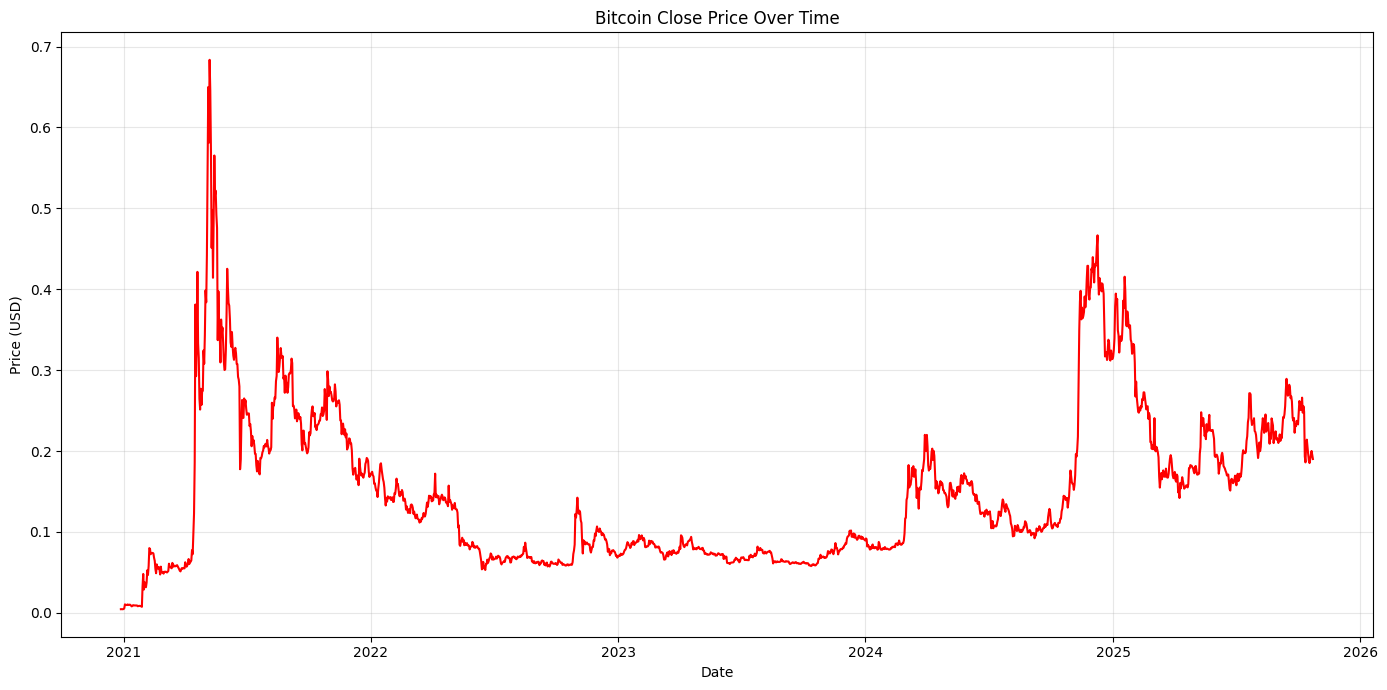

In [25]:
# Visualize closing price
plt.figure(figsize=(14, 7))
plt.title('Bitcoin Close Price Over Time')
plt.plot(df['Close'], color='red', linewidth=1.5)
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [26]:
#Add custom features
df['Returns'] = df['Close'].pct_change()
df['MA_7'] = df['Close'].rolling(window=7).mean()
df['MA_21'] = df['Close'].rolling(window=21).mean()
df['MA_50'] = df['Close'].rolling(window=50).mean()
df['MA_Cross'] = df['MA_7'] - df['MA_21']
df['Volatility_7'] = df['Returns'].rolling(window=7).std()
df['Volatility_21'] = df['Returns'].rolling(window=21).std()
df['Momentum_5'] = df['Close'] - df['Close'].shift(5)
df['Momentum_10'] = df['Close'] - df['Close'].shift(10)
df['Volume_MA'] = df['Volume'].rolling(window=20).mean()
df['Volume_Ratio'] = df['Volume'] / (df['Volume_MA'] + 1e-10)
df['Price_Range'] = (df['High'] - df['Low']) / df['Close']
df['High_Low_Pct'] = (df['High'] - df['Low']) / df['Low']


# --- CHANGE THE TARGET ---
# New Target: Predict the *next day's return*
df['Target_Return'] = df['Close'].pct_change().shift(-1) 
df_original_processed = df.copy()
df = df.dropna()
print(df.columns) # Check new columns

Index(['End', 'Close', 'Open', 'High', 'Low', 'Volume', 'Returns', 'MA_7',
       'MA_21', 'MA_50', 'MA_Cross', 'Volatility_7', 'Volatility_21',
       'Momentum_5', 'Momentum_10', 'Volume_MA', 'Volume_Ratio', 'Price_Range',
       'High_Low_Pct', 'Target_Return'],
      dtype='object')


In [27]:
feature_columns = [
    'Open', 'High', 'Low', 'Close', 'Volume',
    'Returns',
    'MA_7', 'MA_21', 'MA_50', 'MA_Cross',
    'Volatility_7', 'Volatility_21',
    'Momentum_5', 'Momentum_10',
    'Volume_Ratio', 'Price_Range', 'High_Low_Pct',
]
features = df[feature_columns].values

# --- NEW TARGET ---
target_return = df['Target_Return'].values

In [28]:
#creating sequences for LSTM

SEQUENCE_LENGTH = 30

def create_sequences(features, target, seq_n):
    x, y = [], []
    for i in range(seq_n - 1, len(features)):
        x.append(features[i-(seq_n-1):i+1, :]) 
        y.append(target[i])
    return np.array(x), np.array(y)


In [29]:
#train test split
train_n = int(np.ceil(len(features) * 0.8))
scaler = RobustScaler()
scaler.fit(features[0:train_n])
scaled_features = scaler.transform(features)

# --- Use new target_return ---
X, y = create_sequences(scaled_features, target_return, SEQUENCE_LENGTH) 

joblib.dump(scaler, 'scaler_robust.joblib')
split_idx = train_n - (SEQUENCE_LENGTH - 1)
x_train = X[0:split_idx]
y_train = y[0:split_idx] # This is the unscaled y_train
x_test = X[split_idx:]
y_test = y[split_idx:]   # This is the unscaled y_test (actual returns)

# --- ADD TARGET SCALING ---
# Reshape y to 2D for the scaler
y_train_2d = y_train.reshape(-1, 1)
y_test_2d = y_test.reshape(-1, 1)

target_scaler = StandardScaler()
y_train_scaled = target_scaler.fit_transform(y_train_2d) # Fit AND transform train
y_test_scaled = target_scaler.transform(y_test_2d)     # ONLY transform test

joblib.dump(target_scaler, 'target_scaler.joblib') # Save the target scaler

['target_scaler.joblib']

In [30]:
#Model Architechture
test_dates = df.index[train_n:]

input_shape = (x_train.shape[1], x_train.shape[2])

model = Sequential([
    Input(shape=input_shape),
    
    LSTM(64, return_sequences=True),
    BatchNormalization(),
    Dropout(0.3),
    
    LSTM(32, return_sequences=False),
    BatchNormalization(),
    Dropout(0.3),
    
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='linear')
])


In [31]:
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mean_squared_error',
    metrics=['mean_absolute_error']
)

In [32]:
# after frying my laptop with 200 epoch I had to use early stopping ....reduce learning rate on plateau is standard ( i think so)

early_stop = EarlyStopping( 
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=7,
    min_lr=0.00001,
    verbose=1
)

In [33]:
#training the model
history = model.fit(
    x_train, y_train_scaled, # <-- Use y_train_scaled
    batch_size=32,
    epochs=100,
    validation_data=(x_test, y_test_scaled), # <-- Use y_test_scaled
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

Epoch 1/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 1.6605 - mean_absolute_error: 0.8928 - val_loss: 0.5756 - val_mean_absolute_error: 0.5614 - learning_rate: 0.0010
Epoch 2/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.2064 - mean_absolute_error: 0.7173 - val_loss: 0.5747 - val_mean_absolute_error: 0.5588 - learning_rate: 0.0010
Epoch 3/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 1.0935 - mean_absolute_error: 0.6884 - val_loss: 0.5771 - val_mean_absolute_error: 0.5596 - learning_rate: 0.0010
Epoch 4/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 1.1641 - mean_absolute_error: 0.6781 - val_loss: 0.5865 - val_mean_absolute_error: 0.5654 - learning_rate: 0.0010
Epoch 5/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 1.1386 - mean_absolute_error: 0.6573 - val_loss: 0.5873 - val_mean_absolute_error: 0.5645 - learning_rate: 0.0010
Epoch 6/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.0538 - mean_absolute_error: 0.6413 - val_loss: 0.5869 - val_mean_abs

In [34]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score

# Predict the SCALED returns
predicted_returns_scaled = model.predict(x_test)

# --- INVERSE TRANSFORM predictions to get the real return values ---
predicted_returns = target_scaler.inverse_transform(predicted_returns_scaled)
predicted_returns_flat = predicted_returns.flatten()

# y_test is the un-scaled returns (from Cell 66)
test_dates = df.index[train_n:]

# Calculate regression metrics on the *actual return values*
mae = mean_absolute_error(y_test, predicted_returns)
mse = mean_squared_error(y_test, predicted_returns)
r2 = r2_score(y_test, predicted_returns)

print(f"--- Regression Metrics (on Returns) ---")
print(f"Mean Absolute Error (MAE): {mae:.6f}")
print(f"Mean Squared Error (MSE): {mse:.6f}")
print(f"R-squared (R2): {r2:.4f}")

# --- NEW DIRECTIONAL ACCURACY ---
# The signal is just whether the predicted return is positive
actual_moves = (y_test > 0).astype(int)
predicted_moves = (predicted_returns_flat > 0).astype(int) # This is our directional signal

directional_accuracy = accuracy_score(actual_moves, predicted_moves)
print(f"\n--- Directional Metrics ---")
print(f"Directional Accuracy: {directional_accuracy * 100:.2f}%")

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
--- Regression Metrics (on Returns) ---
Mean Absolute Error (MAE): 0.036823
Mean Squared Error (MSE): 0.002496
R-squared (R2): -0.0056

--- Directional Metrics ---
Directional Accuracy: 53.51%


In [35]:
#Market simulation
actual_prices = df['Close'].values[train_n:] # <-- This is used by the plot and sim

initial_capital = 10000
capital = initial_capital
position = 0  # 0 = no position, 1 = holding bitcoin
btc_amount = 0 
entry_price = 0
trades = []
portfolio_value = []

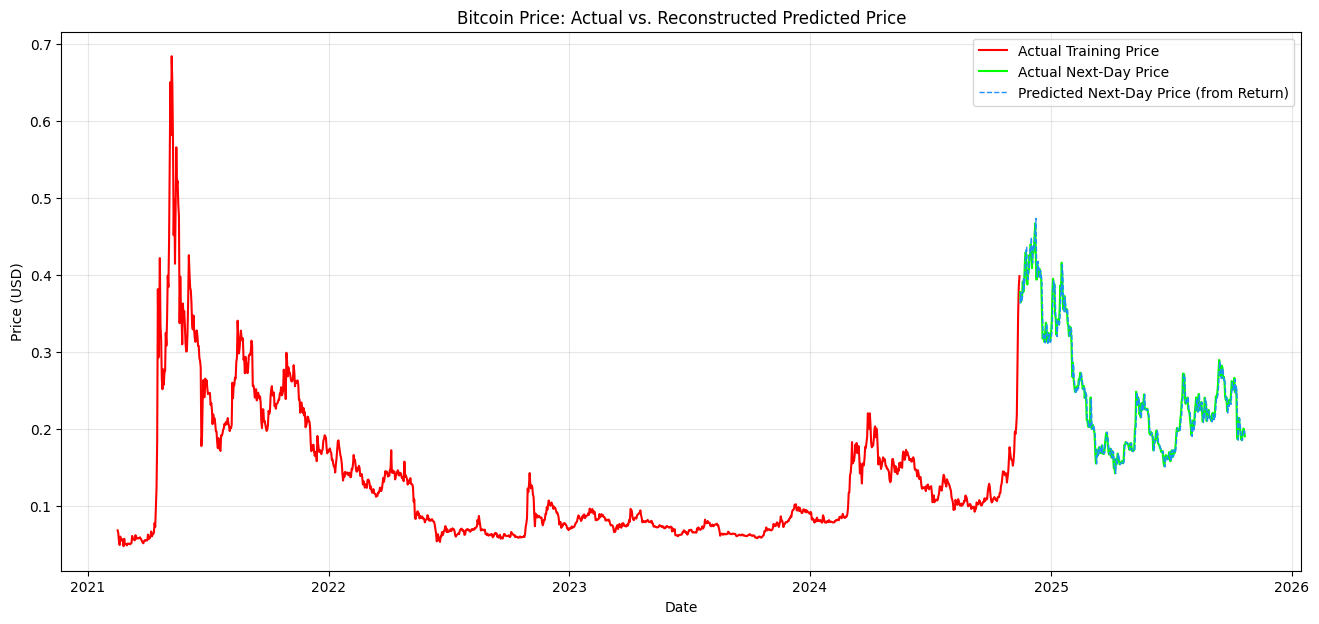

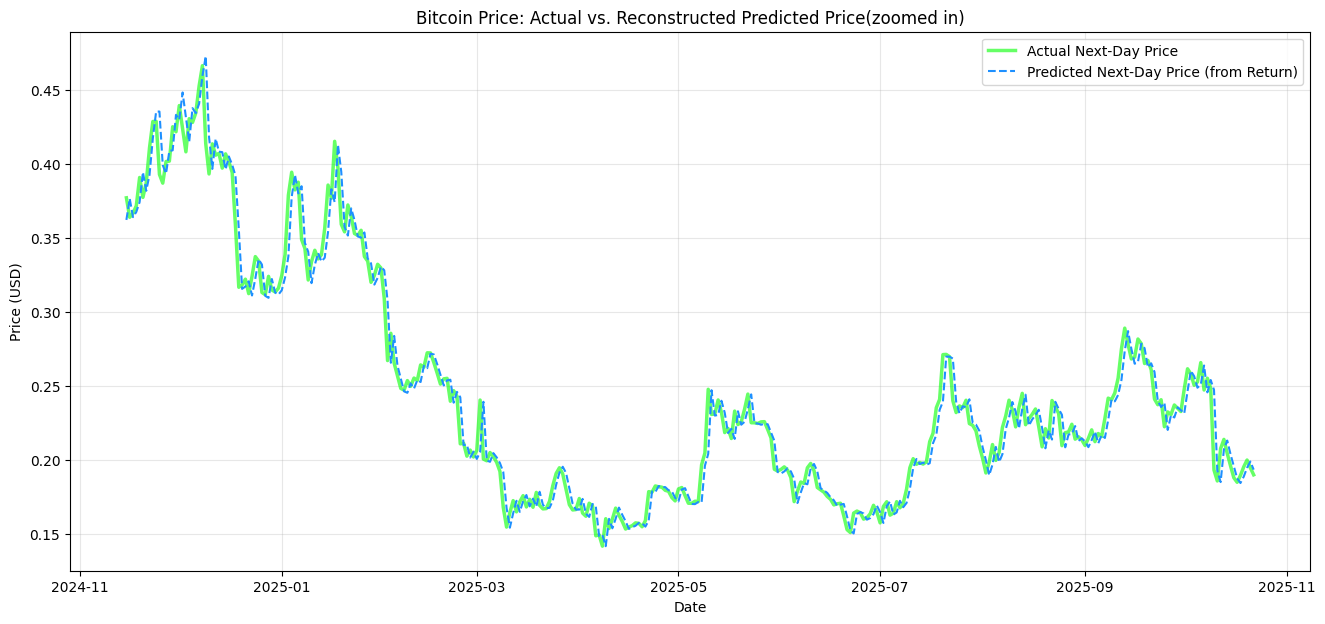

In [36]:

actual_prices_today = actual_prices 

# Ensure all arrays are the same length for plotting
min_len = min(len(actual_prices_today), len(y_test), len(predicted_returns_flat), len(test_dates))

actual_prices_today = actual_prices_today[:min_len]
y_test_actual_returns = y_test[:min_len]
predicted_returns = predicted_returns_flat[:min_len]
plot_dates = test_dates[:min_len]

# 1. Calculate the *ACTUAL* next-day price path
actual_price_next_day = actual_prices_today * (1 + y_test_actual_returns)
dates_train = df.index[:train_n]
prices_train = df['Close'].values[:train_n]
# 2. Calculate the *PREDICTED* next-day price path
predicted_price_next_day = actual_prices_today * (1 + predicted_returns)

# 3. Plot them against each other
plt.figure(figsize=(16, 7))
plt.plot(dates_train, prices_train, label='Actual Training Price', color='red', linewidth=1.5)
plt.plot(plot_dates, actual_price_next_day, label='Actual Next-Day Price', color='lime', linewidth=1.5)
plt.plot(plot_dates, predicted_price_next_day, label='Predicted Next-Day Price (from Return)',color='dodgerblue',linestyle='--', linewidth=1)
plt.title('Bitcoin Price: Actual vs. Reconstructed Predicted Price')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.figure(figsize=(16, 7))
plt.plot(plot_dates, actual_price_next_day, label='Actual Next-Day Price', color='lime', linewidth=2.5,alpha=0.6)
plt.plot(plot_dates, predicted_price_next_day, label='Predicted Next-Day Price (from Return)',color='dodgerblue',linestyle='--', linewidth=1.5)
plt.title('Bitcoin Price: Actual vs. Reconstructed Predicted Price(zoomed in)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [37]:
# --- Use the 'predicted_moves' (0s and 1s) from the evaluation cell (53) ---
predicted_directions = predicted_moves 

# --- The rest of the simulation loop is unchanged ---
for i in range(len(predicted_directions)):
    current_price = actual_prices[i]
    signal = predicted_directions[i] # Use the generated directional signal

    # Buy signal: Predict Up (1) and currently not holding (position == 0)
    if signal == 1 and position == 0:
        position = 1
        entry_price = current_price
        btc_amount = capital / current_price # Calculate amount based on current capital
        capital = 0 # Capital is now in BTC
        trades.append(('BUY', test_dates[i], current_price, btc_amount * entry_price)) # Log value at time of trade
        # print(f"Buying at {current_price}") # Optional print statement

    # Sell signal: Predict Down (0) and currently holding (position == 1)
    elif signal == 0 and position == 1:
        position = 0
        capital = btc_amount * current_price # Calculate capital based on current price
        profit = capital - (btc_amount * entry_price) # Calculate profit based on entry
        trades.append(('SELL', test_dates[i], current_price, capital)) # Log value at time of trade
        btc_amount = 0 # Reset BTC amount
        entry_price = 0 # Reset entry price
        # print(f"Selling at {current_price}") # Optional print statement

    # Calculate current portfolio value for the day
    if position == 1:
        current_value = btc_amount * current_price # Value is BTC amount * current price
    else:
        current_value = capital # Value is the cash capital held

    portfolio_value.append(current_value)

# If still holding Bitcoin at the end of the simulation period, sell at the last known price
if position == 1:
    final_sell_price = actual_prices[-1]
    capital = btc_amount * final_sell_price
    trades.append(('SELL', test_dates[-1], final_sell_price, capital))
    position = 0 # Update position state
    # Update the last portfolio value entry
    if portfolio_value:
         portfolio_value[-1] = capital


# --- Calculate Final Results ---
final_capital = capital # Final capital is the cash held after the loop (and potential final sell)
total_return = ((final_capital - initial_capital) / initial_capital) * 100 if initial_capital > 0 else 0

# --- Print Results (Example - you might have this later) ---
print(f"Initial Capital: ${initial_capital:,.2f}")
print(f"Final Capital: ${final_capital:,.2f}")
print(f"Total Return: {total_return:.2f}%")
print(f"Number of Buys: {len([t for t in trades if t[0] == 'BUY'])}")
print(f"Number of Sells: {len([t for t in trades if t[0] == 'SELL'])}")

Initial Capital: $10,000.00
Final Capital: $12,265.55
Total Return: 22.66%
Number of Buys: 8
Number of Sells: 8


In [38]:
#buy and hold strategy
buy_hold_btc = initial_capital / actual_prices[0]
buy_hold_final = buy_hold_btc * actual_prices[-1]
buy_hold_return = ((buy_hold_final - initial_capital) / initial_capital) * 100




FINAL METRICS & VISUALIZATION
Directional Accuracy (from Regression): 53.51%


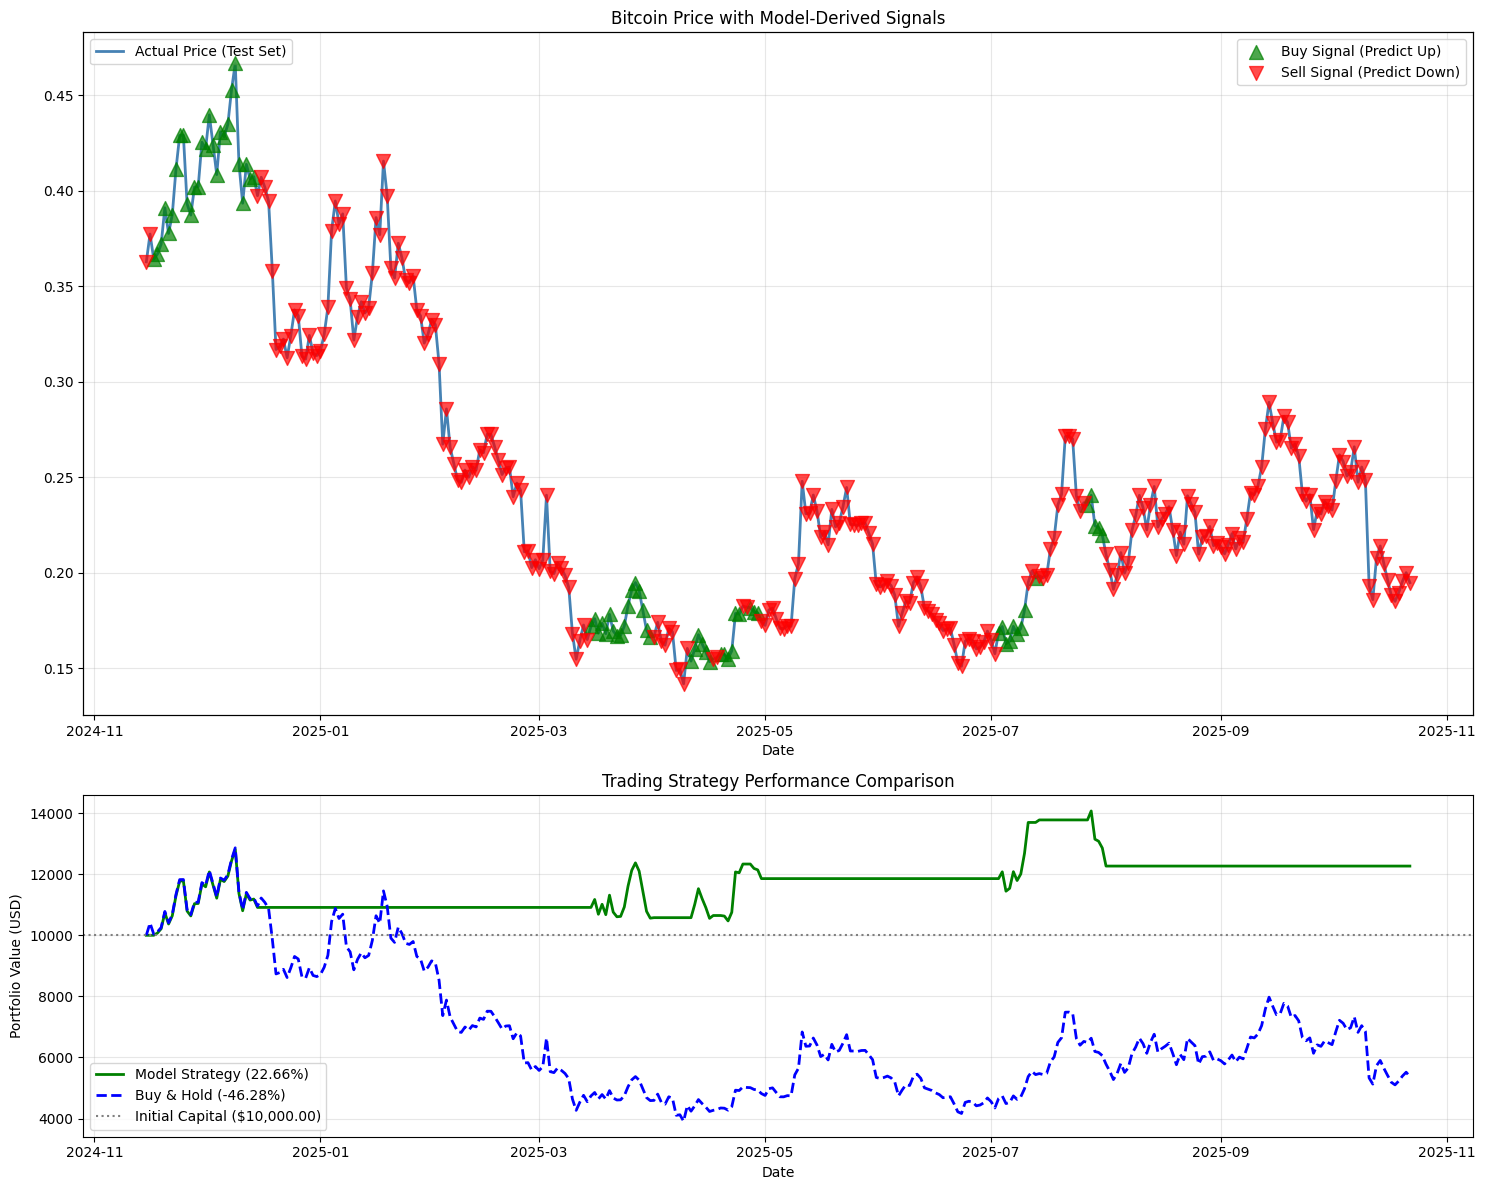

In [39]:
import matplotlib.pyplot as plt

# === VISUALIZATION OF RESULTS ===

print("\n" + "="*60)
print("FINAL METRICS & VISUALIZATION")
print("="*60)

# 1. Print the Directional Accuracy score (calculated in cell 53)
#    (No ROC AUC score as this is a regression model)
print(f"Directional Accuracy (from Regression): {directional_accuracy * 100:.2f}%") # Use the variable from cell 53

# 2. Create the plots
# Ensure lengths match before plotting
if len(predicted_directions) == len(actual_prices) == len(test_dates):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12), gridspec_kw={'height_ratios': [2, 1]})

    # === PLOT 1: Actual Price vs. Derived Signals ===
    ax1.plot(test_dates, actual_prices, label='Actual Price (Test Set)', color='steelblue', linewidth=2)
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Price (USD)', color='white')
    ax1.set_title('Bitcoin Price with Model-Derived Signals')
    ax1.legend(loc='upper left')
    ax1.grid(True, alpha=0.3)

    # Create a second y-axis for signals
    ax1_twin = ax1.twinx()

    # Use 'predicted_directions' (list of 0s and 1s from cell 56) for signals
    buy_indices = [i for i, sig in enumerate(predicted_directions) if sig == 1]
    sell_indices = [i for i, sig in enumerate(predicted_directions) if sig == 0]

    # Plot signals as markers
    ax1_twin.scatter([test_dates[i] for i in buy_indices],
                     [actual_prices[i] for i in buy_indices],
                     color='green', marker='^', s=100, alpha=0.7, label='Buy Signal (Predict Up)')
    ax1_twin.scatter([test_dates[i] for i in sell_indices],
                     [actual_prices[i] for i in sell_indices],
                     color='red', marker='v', s=100, alpha=0.7, label='Sell Signal (Predict Down)')

    ax1_twin.set_yticks([]) # Hide the twin y-axis labels/ticks
    ax1_twin.legend(loc='upper right')

    # === PLOT 2: Portfolio Value vs. Buy & Hold ===
    # Check if portfolio_value has data (it might be constant if no trades occurred)
    if len(portfolio_value) == len(test_dates) and len(actual_prices) > 0:
        buy_hold_value_over_time = (initial_capital / actual_prices[0]) * actual_prices
        ax2.plot(test_dates, portfolio_value, label=f'Model Strategy ({total_return:,.2f}%)', color='green', linewidth=2)
        ax2.plot(test_dates, buy_hold_value_over_time, label=f'Buy & Hold ({buy_hold_return:,.2f}%)', color='blue', linewidth=2, linestyle='--')
        ax2.axhline(y=initial_capital, color='gray', linestyle=':', label=f'Initial Capital (${initial_capital:,.2f})')
        ax2.set_xlabel('Date')
        ax2.set_ylabel('Portfolio Value (USD)')
        ax2.set_title('Trading Strategy Performance Comparison')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
    else:
        # Handle case where simulation didn't run properly or had mismatched lengths
        ax2.text(0.5, 0.5, 'Portfolio data not available or length mismatch for plotting',
                 horizontalalignment='center', verticalalignment='center', transform=ax2.transAxes)
        print("Warning: Could not plot portfolio value due to length mismatch or lack of data.")

    plt.tight_layout()
    plt.show()

else:
    print("\nError: Length mismatch between predicted_directions, actual_prices, or test_dates. Cannot generate plots.")

In [40]:

    print(f"\nInitial Capital: ${initial_capital:,.2f}")
    print(f"Final Capital: ${final_capital:,.2f}")
    print(f"Total Return: {total_return:.2f}%")
    print(f"\nBuy & Hold Strategy:")
    print(f"Final Value: ${buy_hold_final:,.2f}")
    print(f"Total Return: {buy_hold_return:.2f}%")
    print(f"\nNumber of Trades: {len([t for t in trades if t[0] == 'BUY'])}")
    print(f"Directional Accuracy (from Regression): {directional_accuracy * 100:.2f}%")


Initial Capital: $10,000.00
Final Capital: $12,265.55
Total Return: 22.66%

Buy & Hold Strategy:
Final Value: $5,372.15
Total Return: -46.28%

Number of Trades: 8
Directional Accuracy (from Regression): 53.51%
